In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler,PowerTransformer,FunctionTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression


import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly import tools


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline 

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clean-diabetes-data/diabetes_prediction_dataset.csv


**gender**: 
Male = 0
Female = 1
Other = 2
**smoking_history**
No = 0
Yes = 1
Not Available = 2
**diabetes**
No = 0
 Yes = 1

This analysis is based on the guide by Sarah El Shatby as someone getting into the data analytics field. 


# The problem is trying to see what are the big factors when it comes to diabetes and how this can be improved. 

In [2]:
df = pd.read_csv('/kaggle/input/clean-diabetes-data/diabetes_prediction_dataset.csv')
df.head()

gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       1  80.0             0              1                0  25.19   
1       1  54.0             0              0                2  27.32   
2       0  28.0             0              0                0  27.32   
3       1  36.0             0              0                1  23.45   
4       0  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  int64  
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  int64  
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 6.9 MB


In [4]:
numeric_col=["age","bmi"]


In [5]:
v = df[numeric_col].iplot(kind='histogram',subplots=True)
v

In [6]:
corr = df.corr()
corr

gender       age  hypertension  heart_disease  \
gender               1.000000  0.030061     -0.014517      -0.077933   
age                  0.030061  1.000000      0.251171       0.233354   
hypertension        -0.014517  0.251171      1.000000       0.121262   
heart_disease       -0.077933  0.233354      0.121262       1.000000   
smoking_history     -0.086379 -0.194814     -0.092784      -0.012354   
bmi                  0.023009  0.337396      0.147666       0.061198   
HbA1c_level         -0.020086  0.101354      0.080939       0.067589   
blood_glucose_level -0.017165  0.110672      0.084429       0.070066   
diabetes            -0.037752  0.258008      0.197823       0.171727   

                     smoking_history       bmi  HbA1c_level  \
gender                     -0.086379  0.023009    -0.020086   
age                        -0.194814  0.337396     0.101354   
hypertension               -0.092784  0.147666     0.080939   
heart_disease              -0.012354  0.061198     0.067589   
smoking_history             1.000000 -0.175945    -0.032236   
bmi                        -0.175945  1.000000     0.082997   
HbA1c_level                -0.032236  0.082997     1.000000   
blood_glucose_level        -0.036471  0.091261     0.166733   
diabetes                   -0.083177  0.214357     0.400660   

                     blood_glucose_level  diabetes  
gender                         -0.017165 -0.037752  
age                             0.110672  0.258008  
hypertension                    0.084429  0.197823  
heart_disease                   0.070066  0.171727  
smoking_history                -0.036471 -0.083177  
bmi                             0.091261  0.214357  
HbA1c_level                     0.166733  0.400660  
blood_glucose_level             1.000000  0.419558  
diabetes                        0.419558  1.000000

In [7]:
X= df.iloc[:,0:8] 
Y= df.iloc[:,-1]  
Y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: diabetes, Length: 100000, dtype: int64

In [8]:
best_features= SelectKBest(score_func=chi2, k=3)
fit= best_features.fit(X,Y)

In [9]:
df_scores= pd.DataFrame(fit.scores_)
df_columns= pd.DataFrame(X.columns)
df_scores

0
0      59.108856
1   80576.722304
2    3620.485416
3    2832.761069
4     487.047346
5    7407.898843
6    3329.139367
7  211290.674736

In [10]:
features_scores= pd.concat([df_columns, df_scores], axis=1)
features_scores.columns= ['Features', 'Score']
features_scores.sort_values(by = 'Score')

Features          Score
0               gender      59.108856
4      smoking_history     487.047346
3        heart_disease    2832.761069
6          HbA1c_level    3329.139367
2         hypertension    3620.485416
5                  bmi    7407.898843
1                  age   80576.722304
7  blood_glucose_level  211290.674736

In [11]:
X= df[['bmi', 'age', 'blood_glucose_level']]
Y= df[['diabetes']]


In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.4,random_state=100)


In [13]:
logreg= LogisticRegression()
logreg.fit(X_train,y_train.values.ravel())

LogisticRegression()

In [14]:
y_pred=logreg.predict(X_test)
print (X_test) #test dataset
print (y_pred) #predicted values

         bmi   age  blood_glucose_level
22422  28.86  15.0                   80
25747  16.18   2.0                  126
13795  27.32  80.0                  200
68724  23.91  20.0                   80
38923  27.32  49.0                  100
...      ...   ...                  ...
91188  22.13  80.0                  158
27130  25.16  40.0                  100
51929  28.13  80.0                  140
96550  27.32  49.0                  100
41523  27.05  77.0                  200

[40000 rows x 3 columns]
[0 0 1 ... 0 0 1]


In [15]:
from sklearn import metrics
from sklearn.metrics import classification_report
print('Accuracy:',metrics.accuracy_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred, zero_division=1))
print('CL Report: ',metrics.classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.940375
Recall:  0.39870435806831567
Precision:  0.797878609310548
CL Report:                precision    recall  f1-score   support

           0       0.95      0.99      0.97     36604
           1       0.80      0.40      0.53      3396

    accuracy                           0.94     40000
   macro avg       0.87      0.69      0.75     40000
weighted avg       0.93      0.94      0.93     40000



In [16]:
y_pred_proba= logreg.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)


In [17]:
auc= metrics.roc_auc_score(y_test, y_pred_proba)


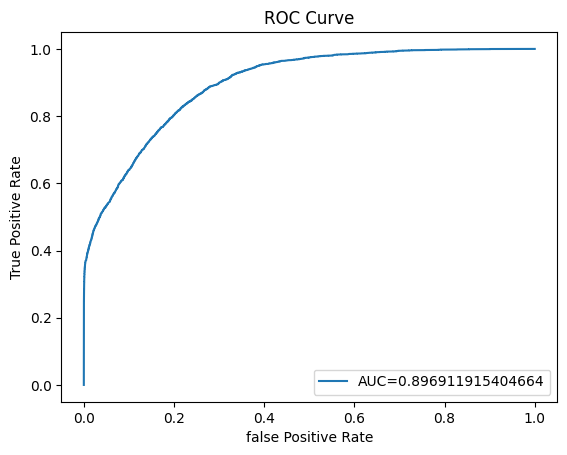

In [18]:
plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

# Conclusion

The factors that play the biggest roles out of the dataset were age, BMI, and blood glucose levels. To combat this issue, spreading more awareness that brings up all of these factors more than the rest can highlight it's importance to both younger and older audiences. This can make people aware to maintain a healthier diet and incorporate physical activity to reduce the possiblity of diabetes, excluding those who genetically have a history of diabetes. 